# Predicting Reservoir Storage

My project examines Folsom Lake, the 10th largest dam in California and a key water supply for millions of its residents. My goal was to create a model that could use exogenous seasonal variables to predict seasonal water supply and its annual minimum. This project is of utmost importance given California's intensifying climate crisis. Folsom Lake is going increasingly deep in its reserves during the extending droughts, having got to as low as 14% of its capacity in 2014. My ultimate goal is to predict the conditions that would cause Folsom Lake to be unusable, ie. near empty and unavailable for use as a water supply for the millions of people who rely on it, the agricultural companies, and the water-species. 

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

from sklearn.model_selection import train_test_split

In [2]:
#load data

precipitation = pd.read_csv('data/folsomlake_daily_precipitation.csv',header=7) #inch total
storage = pd.read_csv('data/folsomlake_daily_storage.csv',header=7) #acre feet
release = pd.read_csv('data/folsomlake_daily_release.csv',header=7) #avg cfs 24 hr
inflow = pd.read_csv('data/folsomlake_daily_inflow.csv',header=7) #avg cfs 24 hr
evaporation = pd.read_csv('data/folsomlake_daily_evaporation.csv',header=7) #sum cfs 24 hr


,Location,Parameter,Result,Units,Timestep,Aggregation,Datetime (UTC)
0,Folsom Lake Dam and Powerplant,Lake/Reservoir Inflow,2000.00,cfs,daily,average,1955-03-01 08:00:00
1,Folsom Lake Dam and Powerplant,Lake/Reservoir Inflow,1966.83,cfs,daily,average,1955-03-02 08:00:00
2,Folsom Lake Dam and Powerplant,Lake/Reservoir Inflow,1832.50,cfs,daily,average,1955-03-03 08:00:00
3,Folsom Lake Dam and Powerplant,Lake/Reservoir Inflow,1983.42,cfs,daily,average,1955-03-04 08:00:00
4,Folsom Lake Dam and Powerplant,Lake/Reservoir Inflow,1899.58,cfs,daily,average,1955-03-05 08:00:00


## Data Preprocesing

In [3]:
#fix data

#drop unnecessary columns

drop_list = ['Location','Parameter','Timestep','Aggregation','Units']

storage.drop(drop_list,axis=1,inplace=True)
precipitation.drop(drop_list,axis=1,inplace=True)
evaporation.drop(drop_list,axis=1,inplace=True)
release.drop(drop_list,axis=1,inplace=True)
inflow.drop(drop_list,axis=1,inplace=True)

In [4]:
# edit df's to start at 1966
start_date = "1966-03-01"
end_date = "2020-03-02"

storage = storage[(storage['Datetime (UTC)'] >= start_date) & (storage['Datetime (UTC)'] <= end_date)]

precipitation = precipitation[(precipitation['Datetime (UTC)'] >= start_date) & (precipitation['Datetime (UTC)'] <= end_date)]

release = release[(release['Datetime (UTC)'] >= start_date) & (release['Datetime (UTC)'] <= end_date)]

evaporation = evaporation[(evaporation['Datetime (UTC)'] >= start_date) & (evaporation['Datetime (UTC)'] <= end_date)]

inflow = inflow[(inflow['Datetime (UTC)'] >= start_date) & (inflow['Datetime (UTC)'] <= end_date)]




In [5]:
#convert cols to datetime, simplify name

storage['date']= pd.to_datetime(storage['Datetime (UTC)']).dt.date
precipitation['date']= pd.to_datetime(precipitation['Datetime (UTC)']).dt.date
evaporation['date']= pd.to_datetime(evaporation['Datetime (UTC)']).dt.date
release['date']= pd.to_datetime(release['Datetime (UTC)']).dt.date
inflow['date']= pd.to_datetime(inflow['Datetime (UTC)']).dt.date

#collect dates in df for future time series

ts_date = storage['date']


#drop duplicate
storage.drop('Datetime (UTC)',axis=1,inplace=True)
precipitation.drop('Datetime (UTC)',axis=1,inplace=True)
evaporation.drop('Datetime (UTC)',axis=1,inplace=True)
release.drop('Datetime (UTC)',axis=1,inplace=True)
inflow.drop('Datetime (UTC)',axis=1,inplace=True)


#set date as index

storage.set_index('date',inplace=True)
precipitation.set_index('date',inplace=True)
evaporation.set_index('date',inplace=True)
release.set_index('date',inplace=True)
inflow.set_index('date',inplace=True)


#set index to datetime format

storage.index = pd.to_datetime(storage.index)
precipitation.index = pd.to_datetime(precipitation.index)
evaporation.index = pd.to_datetime(evaporation.index)
release.index = pd.to_datetime(release.index)
inflow.index = pd.to_datetime(inflow.index)

storage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19725 entries, 1966-03-01 to 2020-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Result  19725 non-null  float64
dtypes: float64(1)
memory usage: 308.2 KB


In [6]:
#rename cols from result to specific 

storage.rename(columns= {'Result': 'storage'},inplace=True)
precipitation.rename(columns= {'Result': 'precipitation'},inplace=True)
evaporation.rename(columns= {'Result': 'evaporation'},inplace=True)
release.rename(columns= {'Result': 'release'},inplace=True)
inflow.rename(columns= {'Result': 'inflow'},inplace=True)





In [7]:
#load data from NOAA on colfax station data

noaa = pd.read_csv('data/colfax_data.csv')

#from 1966 onwards

noaa = noaa[(noaa['DATE'] >= start_date) & (noaa['DATE'] <= end_date)]

noaa.head()

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
2191,USC00041912,"COLFAX, CA US",1966-03-01,NaN,NaN,0.13,0.0,0.0,45.0,32.0,35.0
2192,USC00041912,"COLFAX, CA US",1966-03-02,NaN,NaN,0.00,0.0,0.0,NaN,NaN,NaN
2193,USC00041912,"COLFAX, CA US",1966-03-03,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2194,USC00041912,"COLFAX, CA US",1966-03-04,NaN,NaN,NaN,0.0,0.0,48.0,22.0,45.0
2195,USC00041912,"COLFAX, CA US",1966-03-05,3.0,0.12,NaN,0.0,0.0,58.0,37.0,46.0


In [8]:
#clean noaa
noaa['date'] = pd.to_datetime(noaa['DATE']).dt.date

noaa.drop(['STATION','NAME','DAPR','MDPR','TOBS','DATE','PRCP'],axis=1,inplace=True)



noaa.set_index('date',inplace=True)
noaa.index = pd.to_datetime(noaa.index)

In [9]:
#merge datasets
from functools import reduce
df_list = [noaa,precipitation,evaporation, inflow, release,storage]

data = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'),df_list)

#set index to datetime index

data.index = pd.to_datetime(data.index)
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19725 entries, 1966-03-01 to 2016-07-14
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SNOW           16898 non-null  float64
 1   SNWD           16306 non-null  float64
 2   TMAX           18803 non-null  float64
 3   TMIN           18800 non-null  float64
 4   precipitation  19725 non-null  float64
 5   evaporation    19723 non-null  float64
 6   inflow         19725 non-null  float64
 7   release        19725 non-null  float64
 8   storage        19725 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


## Exploratory Data Analysis

In [10]:
#examine correlations
#pd.hvplot.scatter_matrix(data)

We notice how the data variance rapidly shifted from the 1990's onwards. This makes sense as California's climate has increasingly destabilized, resulting in more need for reservoir water.

<AxesSubplot:xlabel='date'>

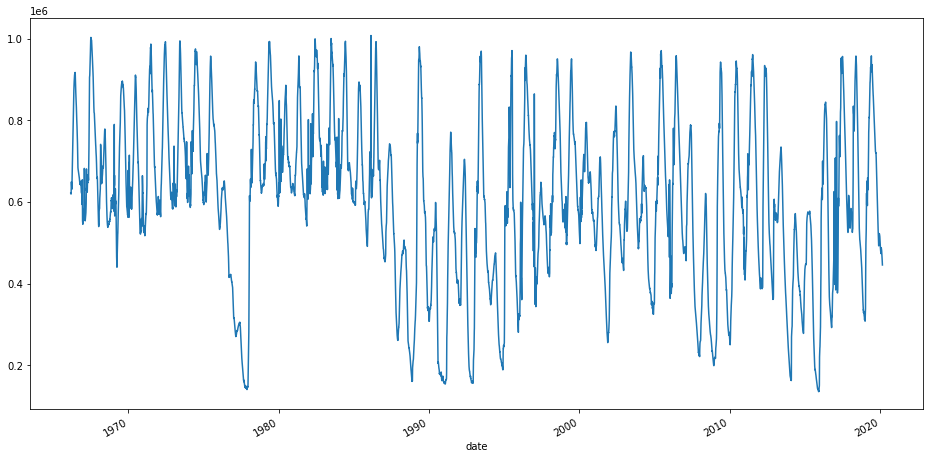

In [11]:
data.storage.plot(figsize=(16,8))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

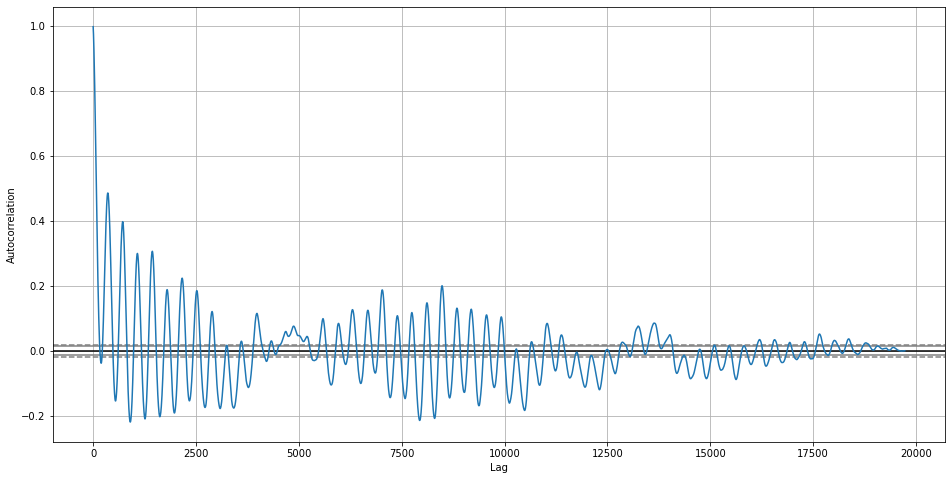

In [12]:
fig, ax1 = plt.subplots(figsize = (16,8))

pd.plotting.autocorrelation_plot(data['storage'],ax=ax1)

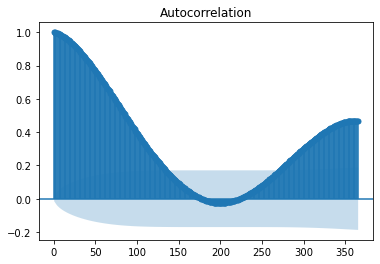

In [25]:
plot_acf(train_ts,lags=365);

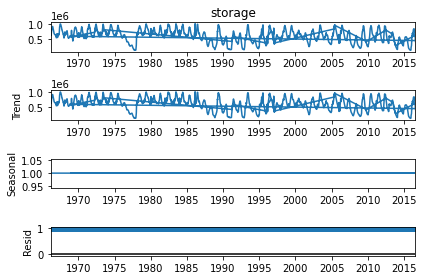

In [13]:
result = seasonal_decompose(pd.Series(data['storage']),model='multiplicative', period=1)

result.plot()
plt.show();

Below, we examine the correlation of reservoir storage data to the past day or past year, and we find it is heavily correlated between the past day, forming an almost perfect line. However, it is surprising the variability year to year. This must be because of the variability in rainfall and seasons in California's diverse climate.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 365)'>

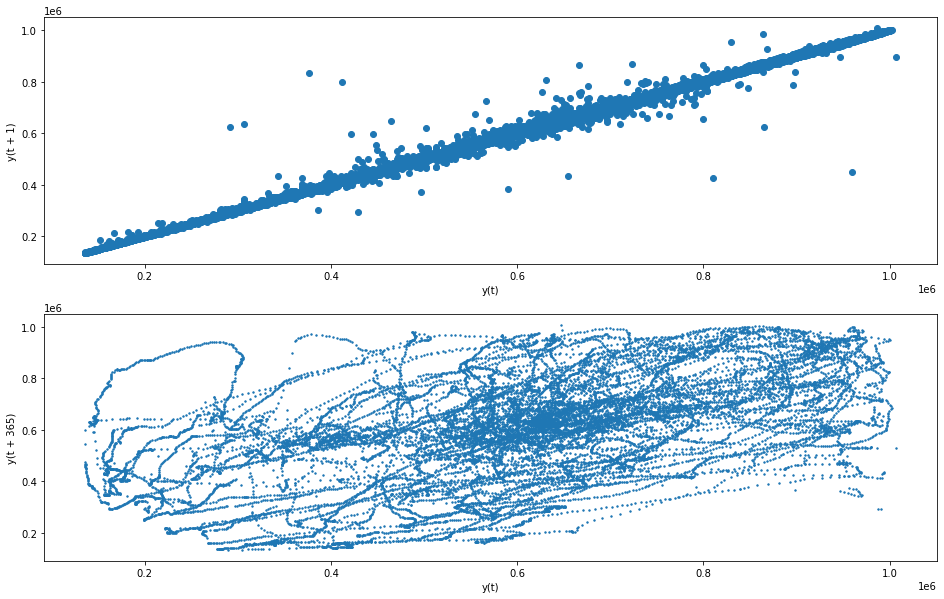

In [14]:
#build rolling data, one set for the 1 day ahead value and one for the 1 year ahead value


fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
pd.plotting.lag_plot(data['storage'],ax=ax1,lag=1)
pd.plotting.lag_plot(data['storage'],ax=ax2,lag=365,s=2)


Examining the storage year after year might tell us why there is so much outlier data.

In [15]:
storage_copy = data['storage'].to_frame()
print(storage_copy.info())

storage_copy

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19725 entries, 1966-03-01 to 2016-07-14
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   storage  19725 non-null  float64
dtypes: float64(1)
memory usage: 308.2 KB
None


,storage
date,
1966-03-01,621844.0
1966-03-02,621844.0
1966-03-03,621661.0
1966-03-04,621113.0
1966-03-05,620656.0
...,...
2013-08-31,429368.0
2013-10-30,294332.0
2013-10-31,291529.0


## Modelling

In [16]:
# build train test split


#set target and data
X = data.drop('storage',axis=1)
y = data['storage']


from sklearn.model_selection import TimeSeriesSplit


#splits data into 80% train, 20% test
tss= TimeSeriesSplit(n_splits=5)

for train, test in tss.split(X):
    X_train, X_test = X.iloc[train,:].fillna(method='ffill'),X.iloc[test,:].fillna(method='ffill')
    y_train, y_test = y.iloc[train].fillna(method='ffill'), y.iloc[test].fillna(method='ffill')
    


In [17]:
ts_date.isna().value_counts()

False    19725
Name: date, dtype: int64

In [18]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

#build endogenous model, with input time only

#train test split time series data
X = ts_date


print(len(ts_date))
print(len(y))


#train test split
for train, test in tss.split(X):
    date_train, date_test = X.iloc[train],X.iloc[test]
    target_train, target_test = y.iloc[train], y.iloc[test]

print(date_train.isna().value_counts(),target_train.isna().value_counts())


train_ts = pd.Series(target_train,index= date_train).fillna(method='ffill')
test_ts = pd.Series(target_test,index=date_test).fillna(method='ffill')

print(train_ts.isna().value_counts())
arma_ts = ARMA(train_ts,order=(2,2))

res_arma = arma_ts.fit()

print(res_arma.summary());

19725
19725
False    16438
Name: date, dtype: int64 False    16438
Name: storage, dtype: int64
False    16438
Name: storage, dtype: int64


/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No f

                              ARMA Model Results                              
Dep. Variable:                storage   No. Observations:                16438
Model:                     ARMA(2, 2)   Log Likelihood             -166388.660
Method:                       css-mle   S.D. of innovations           6021.130
Date:                Mon, 29 Nov 2021   AIC                         332789.319
Time:                        13:33:21   BIC                         332835.563
Sample:                    03-01-1966   HQIC                        332804.594
                         - 03-02-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.063e+05   2.36e+04     25.692      0.000     5.6e+05    6.53e+05
ar.L1.storage     1.9626      0.005    361.159      0.000       1.952       1.973
ar.L2.storage    -0.9629      0.005   -1

In [19]:
res_arma.params

const            606340.017693
ar.L1.storage         1.962576
ar.L2.storage        -0.962876
ma.L1.storage        -0.511469
ma.L2.storage        -0.336647
dtype: float64

In [21]:
#try sarimax model

sarimax1 = SARIMAX(exog = X_train, endog= y_train,order=(2,2,2))

res = sarimax1.fit()

print(res.summary())

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                storage   No. Observations:                16438
Model:               SARIMAX(2, 2, 2)   Log Likelihood             -162630.938
Date:                Mon, 29 Nov 2021   AIC                         325287.875
Time:                        13:33:33   BIC                         325388.069
Sample:                             0   HQIC                        325320.970
                              - 16438                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
SNOW             15.5680     64.314      0.242      0.809    -110.485     141.621
SNWD            -16.8187    244.417     -0.069      0.945    -495.868     462.231
TMAX              9.7932      7.624     

In [ ]:
#test sarimax model